In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime
import re
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split

# from sklearn.surprise import Dataset, Reader
# from surprise.model_selection import train_test_split
# from surprise import SVD

In [184]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

## Data Cleaning

In [185]:
# Checking and removing NaNs
movies_nan = movies.isna().sum()
ratings_nan = ratings.isna().sum()
tags_nan = tags.isna().sum()
links_nan = links.isna().sum()
print("NaN counts in movies:\n", movies_nan)
print("\nNaN counts in ratings:\n", ratings_nan)
print("\nNaN counts in tags:\n", tags_nan)
print("\nNaN counts in links:\n", links_nan)

# TMDB ID the only column with NaNs
links['tmdbId'].fillna('Unknown', inplace=True)



NaN counts in movies:
 movieId    0
title      0
genres     0
dtype: int64

NaN counts in ratings:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

NaN counts in tags:
 userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

NaN counts in links:
 movieId    0
imdbId     0
tmdbId     8
dtype: int64


C:\Users\betht\AppData\Local\Temp\ipykernel_27456\2667525922.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  links['tmdbId'].fillna('Unknown', inplace=True)


In [186]:
# Removing duplicates
ratings.drop_duplicates(subset=['userId', 'movieId'], inplace=True)
tags.drop_duplicates(subset=['userId', 'movieId', 'tag'], inplace=True)

# Data type conversion
movies['movieId'] = movies['movieId'].astype(int)
ratings['userId'] = ratings['userId'].astype(int)
ratings['movieId'] = ratings['movieId'].astype(int)

# Standardising text
movies['title'] = movies['title'].str.lower()
tags['tag'] = tags['tag'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s]', '', x).lower())
movies['genres'] = movies['genres'].str.split('|')

# Extract year from the title and create a new 'year' column
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')

# Remove the year from the 'title' column
movies['title'] = movies['title'].str.rsplit(' (', n=1).str[0]

# Changing format of timestamp
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')




## Data Merging

In [187]:
movie_ratings = pd.merge(movies, ratings, on='movieId')
movie_ratings_tags = pd.merge(movie_ratings, tags, on=['movieId', 'userId'], how='left')
final_dataset = pd.merge(movie_ratings_tags, links, on='movieId', how='left')
final_dataset.head()

,movieId,title,genres,year,userId,rating,timestamp_x,tag,timestamp_y,imdbId,tmdbId
0,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1,4.0,2000-07-30 18:45:03,NaN,NaT,114709,862.0
1,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,5,4.0,1996-11-08 06:36:02,NaN,NaT,114709,862.0
2,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,7,4.5,2005-01-25 06:52:26,NaN,NaT,114709,862.0
3,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,15,2.5,2017-11-13 12:59:30,NaN,NaT,114709,862.0
4,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,17,4.5,2011-05-18 05:28:03,NaN,NaT,114709,862.0


In [188]:
# Checking NaNs
final_dataset_nan = final_dataset.isna().sum()
print("NaN counts in movies:\n", final_dataset_nan)
# Counting non-NaN values in the 'tag' and 'timestamp_y' columns
non_nan_count_tag = final_dataset['tag'].notna().sum()
print("Number of non-NaN values in 'tag':", non_nan_count_tag)
non_nan_count_timestamp_y = final_dataset['timestamp_y'].notna().sum()
print("Number of non-NaN values in 'timestamp_y':", non_nan_count_timestamp_y)

# Fill NaN values in 'tag' with 'No Tag'
final_dataset['tag'].fillna('No Tag', inplace=True)

# Drop 'timestamp_y'
final_dataset.drop(columns=['timestamp_y'], inplace=True)
final_dataset = final_dataset.rename(columns={'timestamp_x': 'timestamp'})
final_dataset.head()

NaN counts in movies:
 movieId            0
title              0
genres             0
year              20
userId             0
rating             0
timestamp_x        0
tag            99201
timestamp_y    99201
imdbId             0
tmdbId             0
dtype: int64
Number of non-NaN values in 'tag': 3476
Number of non-NaN values in 'timestamp_y': 3476


,movieId,title,genres,year,userId,rating,timestamp,tag,imdbId,tmdbId
0,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1,4.0,2000-07-30 18:45:03,No Tag,114709,862.0
1,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,5,4.0,1996-11-08 06:36:02,No Tag,114709,862.0
2,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,7,4.5,2005-01-25 06:52:26,No Tag,114709,862.0
3,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,15,2.5,2017-11-13 12:59:30,No Tag,114709,862.0
4,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,17,4.5,2011-05-18 05:28:03,No Tag,114709,862.0


## Feature Engineering- Timestamps to reflect trends

In [189]:
# Adjust the decay factor
decay_factor = 0.999

# Ensure correct conversion of timestamp to datetime
final_dataset['timestamp'] = pd.to_datetime(final_dataset['timestamp'])

# Age of each rating
current_date = pd.to_datetime('now')
final_dataset['rating_age_days'] = (current_date - final_dataset['timestamp']).dt.days

# Applying decay function
final_dataset['rating_weight'] = decay_factor ** final_dataset['rating_age_days']

# Calculate the weighted rating score
weighted_rating_score = final_dataset.groupby('movieId').apply(lambda x: np.mean(x['rating_weight'])).reset_index(name='weighted_rating_score')

# Normalise the scores 
scaler = MinMaxScaler()
weighted_rating_score['normalised_score'] = scaler.fit_transform(weighted_rating_score[['weighted_rating_score']])

# Merge with the main dataset
final_dataset = final_dataset.merge(weighted_rating_score, on='movieId')
normalised_scores = weighted_rating_score['normalised_score']


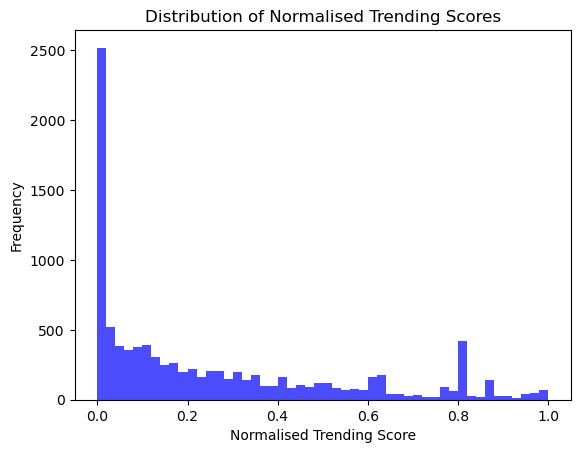

count    102677.000000
mean          0.179590
std           0.161977
min           0.000000
25%           0.073333
50%           0.133584
75%           0.235332
max           1.000000
Name: normalised_score, dtype: float64


In [190]:
# Histogram and info about Trending Scores
plt.hist(normalised_scores, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Normalised Trending Scores')
plt.xlabel('Normalised Trending Score')
plt.ylabel('Frequency')
plt.show()
highest_normalised_score = final_dataset['normalised_score'].describe()
print(highest_normalised_score)


c:\Users\betht\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


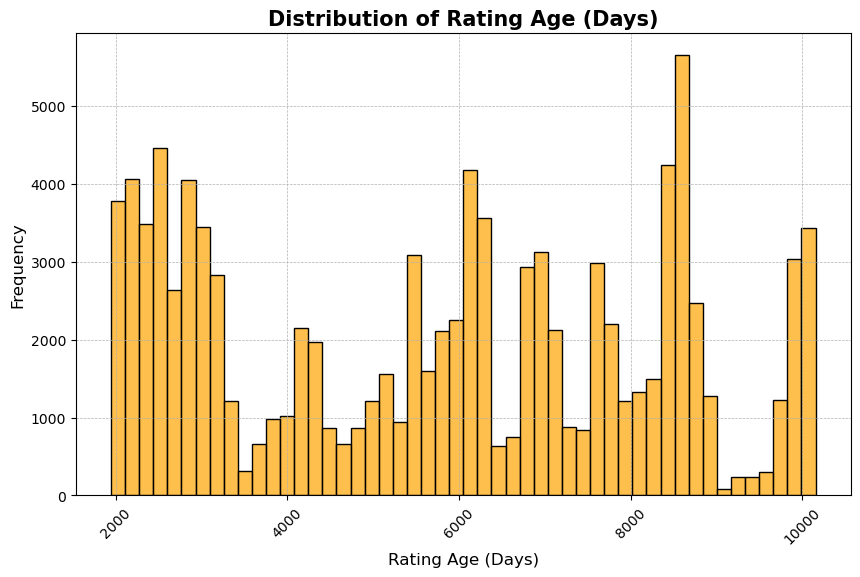

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
#plt.style.use('seaborn-darkgrid')  # You can try different styles like 'ggplot', 'seaborn', etc.

# Create the histogram
plt.figure(figsize=(10, 6))  # Adjust the figure size
sns.histplot(final_dataset['rating_age_days'], bins=50, color='orange', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Rating Age (Days)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Rating Age (Days)', fontsize=15, fontweight='bold')

# Customize ticks
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=10)

# Add gridlines
plt.grid(True, which='major', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()


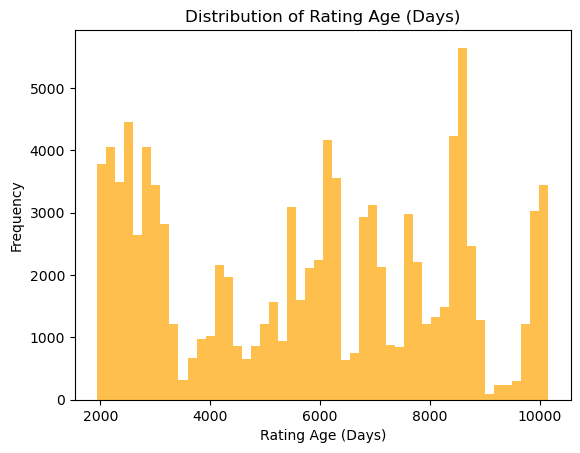

In [192]:
# Check distribution of rating_age_days
plt.hist(final_dataset['rating_age_days'], bins=50, color='orange', alpha=0.7)
plt.title('Distribution of Rating Age (Days)')
plt.xlabel('Rating Age (Days)')
plt.ylabel('Frequency')
plt.show()

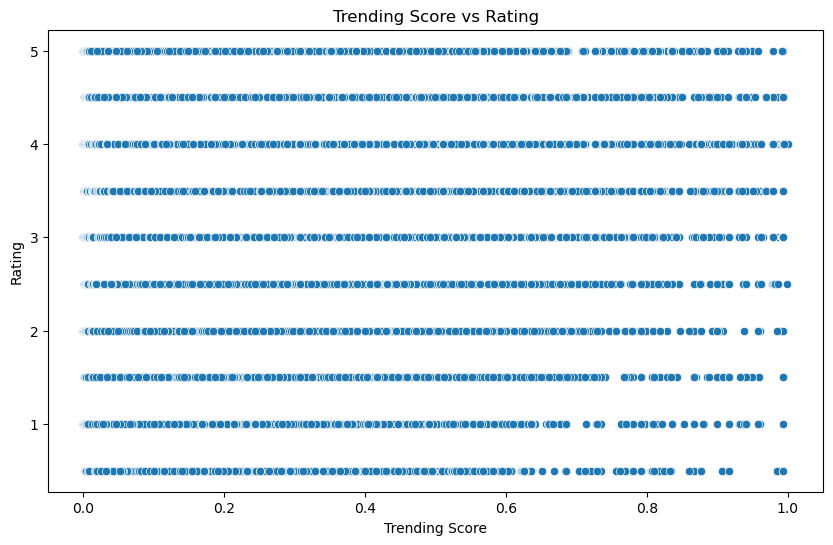

Correlation between Trending Score and Rating: 0.039379475907989694


In [193]:
# Scatter plot of 'trending score' vs 'ratings'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='normalised_score', y='rating', data=final_dataset)
plt.title('Trending Score vs Rating')
plt.xlabel('Trending Score')
plt.ylabel('Rating')
plt.show()

# Calculating the correlation
correlation = final_dataset['normalised_score'].corr(final_dataset['rating'])
print("Correlation between Trending Score and Rating:", correlation)


## RS1- Content-based and collaborative filtering with content analysis

## Content- based filtering

In [194]:
def get_content_based_recommendations(title, cosine_sim, unrated_movies):
    # Get the index of the movie that matches the title
    idx = unrated_movies.index[unrated_movies['title'] == title].tolist()[0]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Filter the movies to only include those that have not been rated by the user
    similar_movies_ids = unrated_movies['movieId'].iloc[movie_indices]
    return pd.DataFrame({'movieId': similar_movies_ids, 'title': unrated_movies['title'].iloc[movie_indices]})


In [195]:
# Extra data cleaning on movies and tags datasets 
movies['genres'] = movies['genres'].astype(str)
tags['tag'] = tags['tag'].astype(str)

# Combine genres and tags 

movies = movies.merge(tags, on='movieId', how='left')
movies['tag'] = movies['tag'].fillna('')
movies['metadata'] = movies['genres'] + ' ' + movies['tag']

# Create a TF-IDF Vectorizer and transform the metadata to a matrix
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies['metadata'])

# Calculate the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to get recommendations based on content similarity
# def get_content_based_recommendations(title, cosine_sim=cosine_sim):
#     # Get the index of the movie that matches the title
#     idx = movies.index[movies['title'] == title].tolist()[0]

#     # Get the pairwise similarity scores of all movies with that movie
#     sim_scores = list(enumerate(cosine_sim[idx]))

#     # Sort the movies based on the similarity scores
#     sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

#     # Get the scores of the 10 most similar movies
#     sim_scores = sim_scores[1:11]

#     # Get the movie indices
#     movie_indices = [i[0] for i in sim_scores]
#     similar_movies_ids = movies['movieId'].iloc[movie_indices]
#     return pd.DataFrame({'movieId': similar_movies_ids, 'title': movies['title'].iloc[movie_indices]})
def get_content_based_recommendations(title, cosine_sim, unrated_movies):
    # Get the index of the movie that matches the title
    idx_list = unrated_movies.index[unrated_movies['title'] == title].tolist()
    
    # Check if index list is empty
    if not idx_list:
        return pd.DataFrame()  # Return empty DataFrame if no match found

    idx = idx_list[0]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices and validate them
    movie_indices = [i[0] for i in sim_scores if i[0] < len(unrated_movies)]

    # Filter the movies to only include those that have not been rated by the user
    similar_movies_ids = unrated_movies['movieId'].iloc[movie_indices]
    return pd.DataFrame({'movieId': similar_movies_ids, 'title': unrated_movies['title'].iloc[movie_indices]})






## Collaborative merged with trending scores

In [196]:

# Load the ratings dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Split the dataset
trainset, testset = train_test_split(data, test_size=0.25)

#Chosen algorithm
svd = SVD()
svd.fit(trainset)

# Predict ratings for the testset
predictions = svd.test(testset)

# Integrate trending scores in the recommendation phase
def get_collaborative_recommendations(user_id, trending_scores, top_n=10):
    # Predict ratings for all movies for the given user
    movie_ids = ratings['movieId'].unique()
    predicted_ratings = [svd.predict(user_id, movie_id).est for movie_id in movie_ids]

    # Combine predictions with trending scores
    movie_rating_trend = pd.DataFrame({'movieId': movie_ids, 'predicted_rating': predicted_ratings})
    movie_rating_trend = movie_rating_trend.merge(trending_scores, on='movieId')

    # Calculating a hybrid score
    movie_rating_trend['hybrid_score'] = movie_rating_trend['predicted_rating'] * movie_rating_trend['normalised_score']

    # Get top N recommendations
    top_recommendations = movie_rating_trend.sort_values(by='hybrid_score', ascending=False).head(top_n)
    return top_recommendations

# Example usage
user_id = 2  
trending_scores = weighted_rating_score[['movieId', 'normalised_score']]  
top_recommendations = get_collaborative_recommendations(user_id, trending_scores, top_n=10)


top_recommendations = top_recommendations.merge(movies[['movieId', 'title']], on='movieId')
print(top_recommendations[['title', 'hybrid_score']])


                                                title  hybrid_score
0                                            tomorrow      3.680851
1       when the levees broke: a requiem in four acts      3.679251
2                days of being wild (a fei jingjyuhn)      3.659327
3                                                 tag      3.649597
4                                        shadow world      3.629711
5                      kizumonogatari iii: cold blood      3.626845
6   too funny to fail: the life and death of the d...      3.610003
7               dc super hero girls: hero of the year      3.601991
8   dragon ball z: the return of cooler (doragon b...      3.600709
9                                          deadpool 2      3.597709
10                                         deadpool 2      3.597709
11                                         deadpool 2      3.597709


## combining the 3

In [197]:
def get_unified_recommendations(user_id, ratings, trending_scores, tfidf_matrix, cosine_sim, movies, top_n=10):
    # Filter out movies already rated by the user
    rated_movie_ids = ratings[ratings['userId'] == user_id]['movieId'].unique()
    unrated_movies = movies[~movies['movieId'].isin(rated_movie_ids)]

    # Get collaborative recommendations
    collaborative_recs = get_collaborative_recommendations(user_id, trending_scores, 5)
    collaborative_recs = collaborative_recs.merge(unrated_movies[['movieId', 'title']], on='movieId', how='left')

    # Initialize an empty DataFrame for content-based recommendations
    content_based_recs = pd.DataFrame()

    for movie_id in collaborative_recs['movieId']:
        if movie_id in rated_movie_ids:  # Skip if the movie is already rated
            continue

        title = unrated_movies[unrated_movies['movieId'] == movie_id]['title'].iloc[0]
        similar_movies = get_content_based_recommendations(title, cosine_sim, unrated_movies)

        if not similar_movies.empty:
            top_similar = similar_movies.head(1)
            if top_similar['movieId'].iloc[0] not in rated_movie_ids:  # Avoid recommending already rated movies
                content_based_recs = pd.concat([content_based_recs, top_similar])

    # Combine collaborative and content-based recommendations
    unified_recommendations = pd.concat([collaborative_recs, content_based_recs]).drop_duplicates(subset=['movieId'])

    # Sort by predicted rating (if available in your data)
    if 'predicted_rating' in unified_recommendations.columns:
        unified_recommendations = unified_recommendations.sort_values(by='predicted_rating', ascending=False)

    # Limit to top N recommendations
    unified_recommendations = unified_recommendations.head(top_n)

    return unified_recommendations

# Example usage
user_id = 4  # Replace with an actual user ID from your dataset
unified_recommendations = get_unified_recommendations(user_id, ratings, trending_scores, tfidf_matrix, cosine_sim, movies, top_n=10)

# Display the recommendations
print(unified_recommendations)


       movieId  predicted_rating  normalised_score  hybrid_score  \
3       179135          3.863665          0.957879      3.700924   
0       117364          3.823615          0.982147      3.755353   
1       193609          3.759400          0.994013      3.736894   
2        95473          3.740229          0.991033      3.706692   
4       193585          3.724638          0.993019      3.698636   
7216     32298               NaN               NaN           NaN   
27          19               NaN               NaN           NaN   
10388   112727               NaN               NaN           NaN   
144        110               NaN               NaN           NaN   
107         77               NaN               NaN           NaN   

                                                   title  
3                                         blue planet ii  
0                                                virunga  
1                           andrew dice clay: dice rules  
2      dragon b

# Splitting Data

In [198]:
import numpy as np
from sklearn.model_selection import train_test_split

# Function to hide some of a user's ratings
def hide_user_ratings(user_id, ratings, hide_ratio=0.25):
    user_ratings = ratings[ratings['userId'] == user_id]
    hide_indices = np.random.choice(user_ratings.index, size=int(len(user_ratings) * hide_ratio), replace=False)
    hidden_ratings = user_ratings.loc[hide_indices]
    visible_ratings = user_ratings.drop(hide_indices)
    return visible_ratings, hidden_ratings

# Function to calculate MAP
def calculate_map(recommendations, hidden_ids):
    relevant = 0
    total_precision = 0
    for k, rec in enumerate(recommendations['movieId'], start=1):
        if rec in hidden_ids:
            relevant += 1
            total_precision += relevant / k
    return total_precision / len(hidden_ids) if hidden_ids else 0

# Function to calculate NDCG
def calculate_ndcg(recommendations, hidden_ids, k=10):
    dcg = sum(1 / np.log2(i + 2) for i, rec in enumerate(recommendations['movieId'].head(k)) if rec in hidden_ids)
    idcg = sum(1 / np.log2(i + 2) for i in range(min(len(hidden_ids), k)))
    return dcg / idcg if idcg > 0 else 0

# Function to calculate MRR
def calculate_mrr(recommendations, hidden_ids):
    for i, rec in enumerate(recommendations['movieId'], start=1):
        if rec in hidden_ids:
            return 1 / i
    return 0

# Function to calculate precision and recall
def calculate_precision_recall(recommendations, hidden_ratings, k=10):
    recommended_ids = set(recommendations['movieId'].head(k))
    hidden_ids = set(hidden_ratings['movieId'])
    hits = recommended_ids.intersection(hidden_ids)
    precision = len(hits) / len(recommended_ids)
    recall = len(hits) / len(hidden_ids) if hidden_ids else 0
    return precision, recall

# Split users into train and test sets
unique_users = ratings['userId'].unique()
train_users, test_users = train_test_split(unique_users, test_size=0.25, random_state=42)

# Initialize lists to store evaluation metrics for each user
precisions = []
recalls = []
mrrs = []
maps = []
ndcgs = []

# Evaluate recommendations for each user in the test set
for user_id in test_users:
    visible_ratings, hidden_ratings = hide_user_ratings(user_id, ratings)
    visible_ratings = pd.concat([ratings[ratings['userId'] != user_id], visible_ratings])

    recommendations = get_unified_recommendations(user_id, visible_ratings, trending_scores, tfidf_matrix, cosine_sim, movies, top_n=10)
    
    # Extract hidden_ids for the current user
    hidden_ids = set(hidden_ratings['movieId'])

    # Calculate metrics
    precision, recall = calculate_precision_recall(recommendations, hidden_ratings, k=10)
    mrr = calculate_mrr(recommendations, hidden_ids)
    map_score = calculate_map(recommendations, hidden_ids)
    ndcg = calculate_ndcg(recommendations, hidden_ids, k=10)

    # Append to lists
    precisions.append(precision)
    recalls.append(recall)
    mrrs.append(mrr)
    maps.append(map_score)
    ndcgs.append(ndcg)

# Calculate average of all metrics across all users
avg_precision = sum(precisions) / len(precisions)
avg_recall = sum(recalls) / len(recalls)
avg_mrr = sum(mrrs) / len(mrrs)
avg_map = sum(maps) / len(maps)
avg_ndcg = sum(ndcgs) / len(ndcgs)

print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')
print(f'Average MRR: {avg_mrr}')
print(f'Average MAP: {avg_map}')
print(f'Average NDCG: {avg_ndcg}')


Average Precision: 0.012872185911401601
Average Recall: 0.00445609150211172
Average MRR: 0.02051302002282394
Average MAP: 0.002469412758747754
Average NDCG: 0.011087682307154166
